<a href="https://colab.research.google.com/github/DMXMax/covid19/blob/gc_20200315/coviddata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests,json
import datetime


In [0]:
covidtrackingurl = "https://covidtracking.com/api/v1/states/daily.json"
response = requests.get(covidtrackingurl)
dfCovidtracking = pd.DataFrame(response.json())
dfCovidtracking.fillna(0, inplace=True)
dfCovidtracking.negative = dfCovidtracking.negative.astype('int64')
dfCovidtracking.positive = dfCovidtracking.positive.astype('int64')
dfCovidtracking.pending = dfCovidtracking.pending.astype('int64')
dfCovidtracking.total = dfCovidtracking.total.astype('int64')
dfCovidtracking.death = dfCovidtracking.death.astype('int64')

dfCovidtracking.date = dfCovidtracking.date.transform(lambda x: pd.to_datetime(datetime.date(x//10000, x%10000//100, x%100
                                          )))


In [0]:
dfWHO = pd.read_csv("https://raw.githubusercontent.com/DMXMax/covid19/master/who/who_data.tsv",
                     sep='\t', index_col='Date')

In [0]:
jhurl = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/"+\
"csse_covid_19_data/csse_covid_19_daily_reports/05-02-2020.csv"


dfJHUData = pd.read_csv(jhurl, header=0,
                        names=['FIPS', 'city','state', 'country', 'last_update',
                               'lat', 'lon','confirmed', 'dead', 'recovered','active', 'key'])

In [0]:
dfWHO = dfWHO.rename(columns={"Confirmed": "confirmed", "Deaths": "who_deaths"})
dfWHO.index.names=['date']


In [58]:
dfCovidtracking.loc[dfCovidtracking.date==dfCovidtracking.date.max(),\
  ['state', 'positive', 'negative', 'totalTestResults']].sort_values(by='positive', ascending=False).head(10)

,state,positive,negative,totalTestResults
37,NY,312977,646094,959071.0
34,NJ,123717,138595,262312.0
21,MA,66263,232731,298994.0
16,IL,58505,241391,299896.0
5,CA,52197,634606,686803.0
41,PA,48305,187071,235376.0
24,MI,43207,158502,201709.0
10,FL,35463,380549,416012.0
47,TX,30522,350126,380648.0
20,LA,29140,143718,172858.0


In [0]:
gbUSA = dfCovidtracking.groupby(['date'])
gbCA = dfCovidtracking[dfCovidtracking.state=='CA'].groupby(['date'])

dfUSAPos = gbUSA[['positive', 'totalTestResults', 'death', 'positiveIncrease','deathIncrease']].sum().reset_index().copy()
dfCAPos = gbCA[['positive', 'totalTestResults', 'death','positiveIncrease', 'deathIncrease']].sum().reset_index().copy()

#This will calculate the percentage each day is of the total. In a flattening, this will be more even
# In a high growth situation, you'll higher percentages at the tail. 
dfUSAPos['PCT']= dfUSAPos.positive/dfUSAPos.max().positive
dfCAPos['PCT']=dfCAPos.positive/dfCAPos.max().positive

In [8]:
dfUSAPos[-14:]


,date,positive,totalTestResults,death,positiveIncrease,deathIncrease,PCT
88,2020-04-19,751287,3891383.0,36224,27511.0,1667.0,0.667384
89,2020-04-20,776419,4038895.0,37913,25132.0,1689.0,0.689709
90,2020-04-21,802330,4186974.0,40471,25911.0,2558.0,0.712727
91,2020-04-22,830223,4501156.0,42508,27893.0,2037.0,0.737505
92,2020-04-23,861788,4693168.0,44385,31565.0,1877.0,0.765545
93,2020-04-24,896306,4925393.0,46251,34518.0,1866.0,0.796208
94,2020-04-25,932242,5196649.0,48069,35936.0,1818.0,0.828130
95,2020-04-26,959258,5403052.0,49164,27016.0,1095.0,0.852129
96,2020-04-27,981134,5593495.0,50327,21876.0,1163.0,0.871562
97,2020-04-28,1005592,5795728.0,52525,24458.0,2198.0,0.893289


In [9]:
dfCAPos[-14:]

,date,positive,totalTestResults,death,positiveIncrease,deathIncrease,PCT
46,2020-04-19,30333,280900.0,1166,1370.0,94.0,0.581125
47,2020-04-20,30978,290500.0,1208,645.0,42.0,0.593482
48,2020-04-21,33261,300100.0,1268,2283.0,60.0,0.637221
49,2020-04-22,35396,465327.0,1354,2135.0,86.0,0.678123
50,2020-04-23,37369,482097.0,1469,1973.0,115.0,0.715922
51,2020-04-24,39254,494173.0,1562,1885.0,93.0,0.752036
52,2020-04-25,41137,506035.0,1651,1883.0,89.0,0.788110
53,2020-04-26,42164,526084.0,1710,1027.0,59.0,0.807786
54,2020-04-27,43464,553409.0,1755,1300.0,45.0,0.832692
55,2020-04-28,45031,577608.0,1809,1567.0,54.0,0.862712


In [10]:
gbUSA.sum()[-5:]

,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,death,hospitalized,total,totalTestResults,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
date,,,,,,,,,,,,,,,,,,,,
2020-04-28,1005592,4790136,4206,54940.0,106308.0,9491.0,3798.0,4760.0,195.0,139342.0,52525,106308.0,5799934,5795728.0,5795728.0,2198.0,2059.0,177775.0,24458.0,202233.0
2020-04-29,1033157,4993013,4832,54930.0,109690.0,9612.0,4093.0,4796.0,365.0,147484.0,55225,109690.0,6031002,6026170.0,6026170.0,2700.0,3382.0,202877.0,27565.0,230442.0
2020-04-30,1062134,5184558,2775,53793.0,111955.0,9486.0,4192.0,4712.0,373.0,154793.0,57316,111955.0,6249467,6246692.0,6246692.0,2091.0,2265.0,191545.0,28977.0,220522.0
2020-05-01,1095681,5456129,1639,52370.0,121748.0,9205.0,4300.0,4707.0,376.0,164015.0,59059,121748.0,6553449,6551810.0,6551810.0,1743.0,9793.0,271571.0,33547.0,305118.0
2020-05-02,1125719,5690628,1578,51554.0,123860.0,9403.0,4386.0,4845.0,375.0,175382.0,60710,123860.0,6817925,6816347.0,6816347.0,1651.0,2112.0,234499.0,30038.0,264537.0


In [11]:
gbCA.sum()[-5:]

,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,death,hospitalized,total,totalTestResults,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
date,,,,,,,,,,,,,,,,,,,,
2020-04-28,45031,532577,0,4983.0,0.0,1485.0,0.0,0.0,0.0,0.0,1809,0.0,577608,577608.0,577608.0,54.0,0.0,22632.0,1567.0,24199.0
2020-04-29,46500,556639,0,5011.0,0.0,1512.0,0.0,0.0,0.0,0.0,1887,0.0,603139,603139.0,603139.0,78.0,0.0,24062.0,1469.0,25531.0
2020-04-30,48917,576420,0,4981.0,0.0,1473.0,0.0,0.0,0.0,0.0,1982,0.0,625337,625337.0,625337.0,95.0,0.0,19781.0,2417.0,22198.0
2020-05-01,50442,604543,0,4706.0,0.0,1434.0,0.0,0.0,0.0,0.0,2073,0.0,654985,654985.0,654985.0,91.0,0.0,28123.0,1525.0,29648.0
2020-05-02,52197,634606,0,4722.0,0.0,1433.0,0.0,0.0,0.0,0.0,2171,0.0,686803,686803.0,686803.0,98.0,0.0,30063.0,1755.0,31818.0


In [83]:
rn = gbCA.sum().loc['2020-05-02']
rn.positive/rn.totalTestResults*100

7.599995923139533

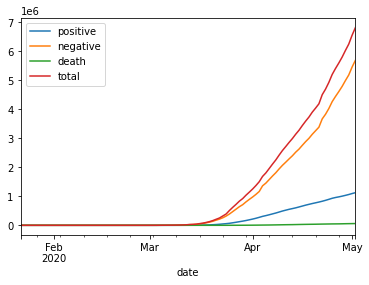

In [12]:
x=gbUSA.sum().loc[:, ['positive', 'negative','death','total']].plot.line()

In [13]:
dfWHO[-14:]

,confirmed,who_deaths
date,,
2020-04-19,695353,32427
2020-04-20,723605,34203
2020-04-21,751273,35884
2020-04-22,776907,37602
2020-04-23,800926,40073
2020-04-24,830053,42311
2020-04-25,860772,44053
2020-04-26,899281,46204
2020-04-27,931698,47980


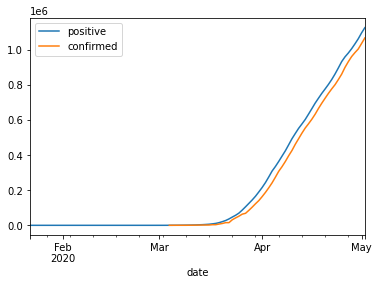

In [14]:
dfResults = gbUSA.sum().join(dfWHO, how='left', rsuffix='_who' )
dfResults.loc[:, ['positive', 'confirmed']].plot.line()

In [15]:
gbCA.sum()[-7:]

,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,death,hospitalized,total,totalTestResults,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
date,,,,,,,,,,,,,,,,,,,,
2020-04-26,42164,483920,0,4928.0,0.0,1473.0,0.0,0.0,0.0,0.0,1710,0.0,526084,526084.0,526084.0,59.0,0.0,19022.0,1027.0,20049.0
2020-04-27,43464,509945,0,4878.0,0.0,1499.0,0.0,0.0,0.0,0.0,1755,0.0,553409,553409.0,553409.0,45.0,0.0,26025.0,1300.0,27325.0
2020-04-28,45031,532577,0,4983.0,0.0,1485.0,0.0,0.0,0.0,0.0,1809,0.0,577608,577608.0,577608.0,54.0,0.0,22632.0,1567.0,24199.0
2020-04-29,46500,556639,0,5011.0,0.0,1512.0,0.0,0.0,0.0,0.0,1887,0.0,603139,603139.0,603139.0,78.0,0.0,24062.0,1469.0,25531.0
2020-04-30,48917,576420,0,4981.0,0.0,1473.0,0.0,0.0,0.0,0.0,1982,0.0,625337,625337.0,625337.0,95.0,0.0,19781.0,2417.0,22198.0
2020-05-01,50442,604543,0,4706.0,0.0,1434.0,0.0,0.0,0.0,0.0,2073,0.0,654985,654985.0,654985.0,91.0,0.0,28123.0,1525.0,29648.0
2020-05-02,52197,634606,0,4722.0,0.0,1433.0,0.0,0.0,0.0,0.0,2171,0.0,686803,686803.0,686803.0,98.0,0.0,30063.0,1755.0,31818.0


In [16]:
dfJHUData[dfJHUData.country=='US'][['confirmed', 'dead']].sum()

confirmed    1069424
dead           62996
dtype: int64

In [17]:
dfJHUData[(dfJHUData.country=='US')&(dfJHUData.state=='California')][['confirmed', 'dead']].sum()

confirmed    50130
dead          2031
dtype: int64

In [0]:
dfJHUUS = dfJHUData[dfJHUData.country=='US']
gbJHUByState= dfJHUUS.groupby(by='state')
gbJHUByCountry = dfJHUData.groupby(by='country')

In [19]:
gbJHUByCountry.confirmed.sum().sort_values(ascending=False).head(10)

country
US                1069424
Spain              213435
Italy              205463
United Kingdom     172481
France             167299
Germany            163009
Turkey             120204
Russia             106498
Iran                94640
Brazil              87187
Name: confirmed, dtype: int64

In [0]:
dfData = dfCovidtracking.groupby('date')

In [0]:
dfStateTotal = dfCovidtracking[['state', 'positive']].groupby(by='state').max() \
.rename(columns={'positive':'current_total'})


In [0]:
dfState = dfCovidtracking[['date','state','positive', 'death']].set_index('state') \
  .join(dfStateTotal)

In [0]:
dfState['pct']=dfState.positive/dfState.current_total

In [24]:
dfState.loc['FL'].head(7)

,date,positive,death,current_total,pct
state,,,,,
FL,2020-05-02,35463,1388,35463,1.000000
FL,2020-05-01,34728,1314,35463,0.979274
FL,2020-04-30,33690,1290,35463,0.950004
FL,2020-04-29,33193,1240,35463,0.935990
FL,2020-04-28,32846,1154,35463,0.926205
FL,2020-04-27,32138,1101,35463,0.906240
FL,2020-04-26,31528,1094,35463,0.889039


In [0]:
res = dfState.reset_index().pivot(index = 'date', columns='state', values='pct').fillna(0)

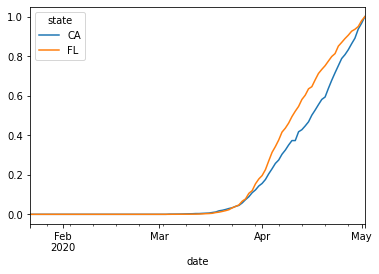

In [26]:
x = res.loc[:, ['CA','FL']].plot.line()

In [0]:
dfNYTesting = dfCovidtracking.loc[dfCovidtracking.state=='NY', ['date', 'negative']].set_index('date')

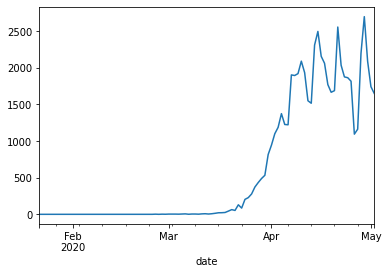

In [28]:
x = dfCovidtracking.groupby(by='date')
#y=x.positive.plot.line()
y1=x.sum().deathIncrease.plot.line()

In [0]:
def getWeek(dt):
  return (dt.year*100)+dt.week

dfByWeekYear = dfCovidtracking.set_index('date')[['deathIncrease', 'hospitalizedIncrease', 'negativeIncrease','positiveIncrease','totalTestResultsIncrease']].groupby(by=getWeek)


In [30]:
dfByWeekYear.sum()[:-1]

,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
202004,0.0,0.0,0.0,0.0,0.0
202005,0.0,0.0,0.0,0.0,0.0
202006,0.0,0.0,0.0,1.0,1.0
202007,0.0,0.0,0.0,0.0,0.0
202008,0.0,0.0,0.0,0.0,0.0
202009,8.0,0.0,81.0,28.0,109.0
202010,23.0,0.0,2821.0,595.0,3416.0
202011,46.0,0.0,30203.0,4114.0,34317.0
202012,359.0,2498.0,179297.0,31482.0,210779.0
202013,2091.0,13766.0,497952.0,107963.0,605915.0


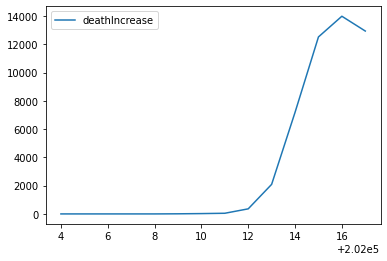

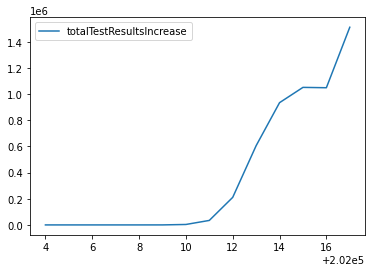

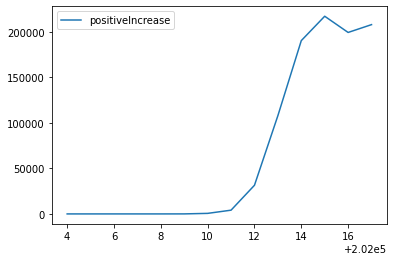

In [31]:
plt1 = dfByWeekYear.sum()[:-1][['deathIncrease']].plot.line()
plt2 = dfByWeekYear.sum()[:-1][['totalTestResultsIncrease']].plot.line()
plt3 = dfByWeekYear.sum()[:-1][['positiveIncrease']].plot.line()

In [32]:
dfDates = dfState.reset_index().copy()
dfDates[(dfDates.state.isin(['FL']))].head(10)

,state,date,positive,death,current_total,pct
574,FL,2020-05-02,35463,1388,35463,1.000000
575,FL,2020-05-01,34728,1314,35463,0.979274
576,FL,2020-04-30,33690,1290,35463,0.950004
577,FL,2020-04-29,33193,1240,35463,0.935990
578,FL,2020-04-28,32846,1154,35463,0.926205
579,FL,2020-04-27,32138,1101,35463,0.906240
580,FL,2020-04-26,31528,1094,35463,0.889039
581,FL,2020-04-25,30839,1075,35463,0.869611
582,FL,2020-04-24,30174,1031,35463,0.850859
583,FL,2020-04-23,28832,979,35463,0.813016


In [33]:
datecutoff = dfDates.date.max()-datetime.timedelta(days=3)
dfDates[(dfDates.date == datecutoff) & (dfDates.pct < .7)].sort_values(by='pct')


,state,date,positive,death,current_total,pct
1833,NE,2020-04-29,3374,55,4838,0.697396


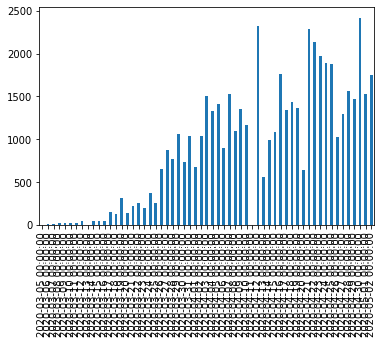

In [34]:
state = 'CA'
dfState = dfCovidtracking[dfCovidtracking.state==state].sort_values(by='date')
vals = dfState.positive.values

x=pd.Series([y-x for x,y in zip(vals,vals[1:])], \
          index = dfCovidtracking[dfCovidtracking.state==state]\
          .sort_values(by='date').date.values[1:] ) \
          .plot.bar()



# Added State Data

In [0]:
data_url = "https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/national/totals/nst-est2019-alldata.csv"


In [0]:
dfUSPop = pd.read_csv(data_url)

In [68]:
import math
us_pop = dfUSPop.loc[0].POPESTIMATE2019 #Estimate from Wikipedia
res = dfCovidtracking.loc[dfCovidtracking.date==dfCovidtracking.date.max(), ['positive', 'negative', 'pending','death', 'total']].sum()
cir = res.positive/res.total
cfr = res.death/res.positive
p_aff= math.ceil(us_pop*cir)
p_dead= math.ceil(p_aff*cfr)
print(res)
print(f"Current Infection Rate {cir*100:2f}%")
print(f"Percentage of US affected: {(res.positive+res.death)/us_pop*100:2f}%")
print(f"Observed CFR: {cfr*100:2f}%")
print(f"Percentage of US tested/affected: {(res.negative+res.positive+res.death)/us_pop*100:2f}%")
print(f"Projected affected by cir = {p_aff:,d}")
print(f"Projected killed = {p_dead:,d}")


positive    1125719
negative    5690628
pending        1578
death         60710
total       6817925
dtype: int64
Current Infection Rate 16.511167%
Percentage of US affected: 0.361452%
Observed CFR: 5.392998%
Percentage of US tested/affected: 2.095134%
Projected affected by cir = 54,196,177
Projected killed = 2,922,799


In [0]:
!if [ ! -d "loc" ]; then \
git clone https://gist.github.com/rogerallen/1583593 --depth=1 --quiet loc; \
fi
import sys
sys.path.append("loc")




In [0]:
import us_state_abbrev as us_abbr


In [0]:
dfStatePop = dfUSPop[dfUSPop.STATE != 0].copy()

In [0]:
dfStatePop['ABBR']=dfStatePop.NAME.apply(lambda x: us_abbr.us_state_abbrev[x])

In [0]:
dfStatePop = dfStatePop.loc[:, ['ABBR', 'POPESTIMATE2019']]
dfStatePop.set_index('ABBR', inplace=True)

In [0]:
dfStateCovid = dfCovidtracking.loc[dfCovidtracking.date==dfCovidtracking.date.max()].set_index('state')

In [0]:
dfStateJoin = dfStateCovid.join(dfStatePop)

In [45]:
pd.DataFrame([(dfStateJoin.positive / dfStateJoin.POPESTIMATE2019)*100, \
              (dfStateJoin.totalTestResults/ dfStateJoin.POPESTIMATE2019)*100],\
             index=['state_pos_pop','state_test_pop'] ).T.sort_values(by="state_pos_pop", ascending=False)[:51]

,state_pos_pop,state_test_pop
state,,
NY,1.608842,4.930054
NJ,1.392866,2.953236
MA,0.961378,4.337960
RI,0.876849,6.600960
CT,0.806779,2.812032
DC,0.679703,3.117822
LA,0.626829,3.718341
DE,0.517374,2.373470
IL,0.461694,2.366637


In [46]:
#print(f"Current Infection Rate {res.positive/res.total*100:2f}%")

print(f"Current Testing Percent {gbUSA.sum().tail(1).totalTestResults[0]/dfUSPop[dfUSPop.REGION=='0'].POPESTIMATE2019[0]*100:2f}%")

Current Testing Percent 2.076638%


In [47]:
dfJHUData.columns

Index(['FIPS', 'city', 'state', 'country', 'last_update', 'lat', 'lon',
       'confirmed', 'dead', 'recovered', 'active', 'key'],
      dtype='object')

In [0]:
dfOwid = pd.read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv")

In [49]:
dfOwid.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14919 entries, 0 to 14918
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   iso_code                  14730 non-null  object 
 1   location                  14919 non-null  object 
 2   date                      14919 non-null  object 
 3   total_cases               14919 non-null  int64  
 4   new_cases                 14919 non-null  int64  
 5   total_deaths              14919 non-null  int64  
 6   new_deaths                14919 non-null  int64  
 7   total_cases_per_million   14629 non-null  float64
 8   new_cases_per_million     14629 non-null  float64
 9   total_deaths_per_million  14629 non-null  float64
 10  new_deaths_per_million    14629 non-null  float64
 11  total_tests               3697 non-null   float64
 12  new_tests                 3302 non-null   float64
 13  total_tests_per_thousand  3697 non-null   float64
 14  new_te

In [0]:
dfOwidTests = dfOwid.dropna(subset=['total_tests']).copy()

In [0]:
dfOwidLatest = dfOwidTests.sort_values(by='date').groupby('iso_code').last()

In [53]:
dfOwidLatest.total_tests.sort_values(ascending=False)

iso_code
USA    6551810.0
RUS    3945518.0
DEU    2547052.0
ITA    2053425.0
TUR    1075048.0
         ...    
PRY      10327.0
CRI       9502.0
ZWE       8314.0
MMR       8281.0
BOL       6613.0
Name: total_tests, Length: 82, dtype: float64

In [54]:
isUSA = dfOwidLatest.index.isin(['USA'])
NonUSTests = dfOwidLatest[~isUSA].total_tests.sum()
USTests = dfOwidLatest[isUSA].total_tests.sum()

print(f"Total testing done outside of USA: {NonUSTests:.0f}")
print(f"Total tests done in USA : {USTests:.0f}")
print(f"How many more times has the world tested more than the US: {NonUSTests/USTests:.1f}")

Total testing done outside of USA: 23865874
Total tests done in USA : 6551810
How many more times has the world tested more than the US: 3.6


In [55]:
dfOwidLatest[isUSA].sum()

location                                                  United States
date                                                         2020-05-01
total_cases                                                     1069826
new_cases                                                         29917
total_deaths                                                      63006
new_deaths                                                         2040
total_cases_per_million                                         3232.08
new_cases_per_million                                            90.383
total_deaths_per_million                                        190.349
new_deaths_per_million                                            6.163
total_tests                                                 6.55181e+06
new_tests                                                        305118
total_tests_per_thousand                                         19.794
new_tests_per_thousand                                          

In [78]:
dfOwidUSA = dfOwid.loc[dfOwid.iso_code=='USA']
dfOwidUSA.set_index('date')[['new_cases','new_deaths']][-14:]

,new_cases,new_deaths
date,,
2020-04-20,24601,1772
2020-04-21,28065,1857
2020-04-22,37289,2524
2020-04-23,17588,1721
2020-04-24,26543,3179
2020-04-25,21352,1054
2020-04-26,48529,2172
2020-04-27,26857,1687
2020-04-28,22541,1369


In [80]:
dfOwidUSA.set_index('date')

,iso_code,location,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,tests_units
date,,,,,,,,,,,,,,,
2019-12-31,USA,United States,0,0,0,0,0.000,0.000,0.000,0.000,NaN,NaN,NaN,NaN,NaN
2020-01-01,USA,United States,0,0,0,0,0.000,0.000,0.000,0.000,NaN,NaN,NaN,NaN,NaN
2020-01-02,USA,United States,0,0,0,0,0.000,0.000,0.000,0.000,NaN,NaN,NaN,NaN,NaN
2020-01-03,USA,United States,0,0,0,0,0.000,0.000,0.000,0.000,NaN,NaN,NaN,NaN,NaN
2020-01-04,USA,United States,0,0,0,0,0.000,0.000,0.000,0.000,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-29,USA,United States,1012583,24132,58355,2110,3059.139,72.906,176.298,6.375,6026170.0,230442.0,18.206,0.696,inconsistent units (COVID Tracking Project)
2020-04-30,USA,United States,1039909,27326,60966,2611,3141.694,82.555,184.186,7.888,6246692.0,220522.0,18.872,0.666,inconsistent units (COVID Tracking Project)
2020-05-01,USA,United States,1069826,29917,63006,2040,3232.077,90.383,190.349,6.163,6551810.0,305118.0,19.794,0.922,inconsistent units (COVID Tracking Project)
